Random Forest

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:36:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.3432

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.14      0.03      0.05        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.17      0.04      0.06       355
   happiness       0.34      0.30      0.32      1042
        hate       0.37      0.16      0.23       265
        love       0.49      0.39      0.43       768
     neutral       0.33      0.64      0.43      1728
      relief       0.19      0.05      0.08       305
     sadness       0.36      0.24      0.29      1033
    surprise       0.17      0.03      0.06       437
       worry       0.35      0.41      0.38      1692

    accuracy                           0.34      8000
   macro avg       0.22      0.18      0.18      8000
weighted avg       0.32      0.34      0.31      8000



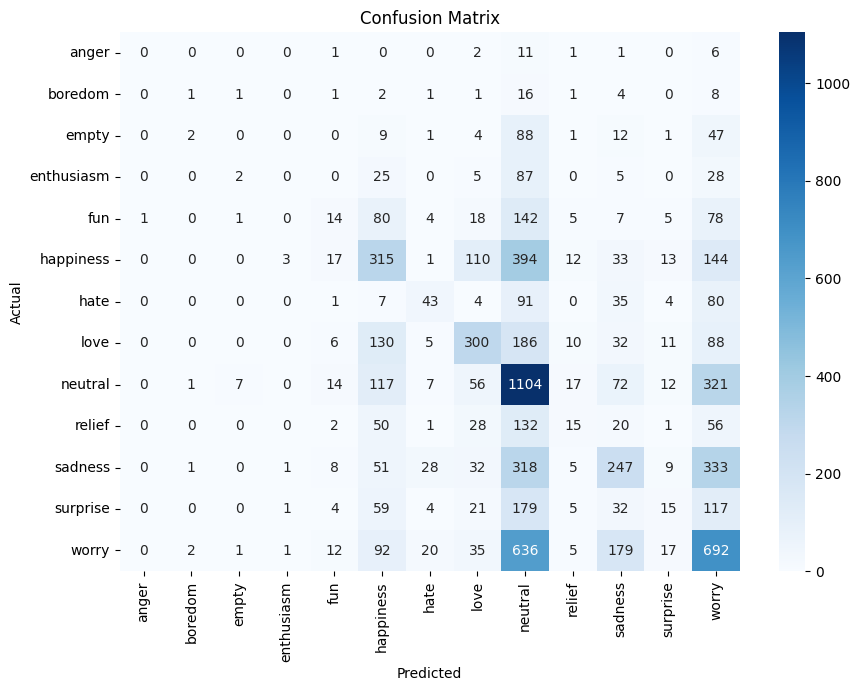

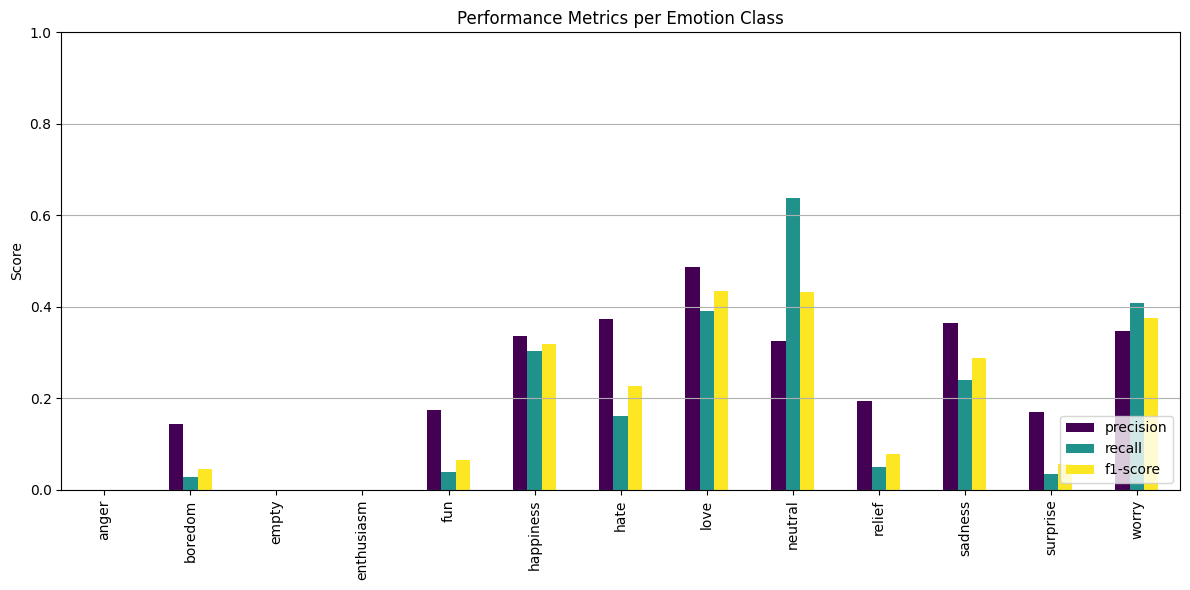

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("/content/drive/MyDrive/Emotion Detection Text/tweet_emotions.csv")

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_content'] = df['content'].apply(clean_text)

label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['sentiment'])

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_content'])
y = df['encoded_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

!pip install xgboost
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=200, learning_rate=0.3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred, output_dict=True, target_names=label_encoder.classes_)
report_df = pd.DataFrame(report).transpose()

metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.loc[label_encoder.classes_, metrics]

report_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Performance Metrics per Emotion Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
